# Floresta Aleatória

## Carregando Biblioteca

In [7]:
library(repr)
library(caTools)
options(repr.plot.width = 8, repr.plot.height = 8)
#Floresta Aleatória
library(randomForest)
#Preprocessamento
library(CatEncoders)
library(gplots)
#Matricas
library(caret)

## Carregando os dados

In [8]:
df <- read.csv("../datasets/titanic/train.csv", na.strings = '')
head(df)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q


## Pré-Processamento de Dados

In [9]:
# Extração de Pronomes
df$Name <- ifelse(grepl(", Mr. ", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Capt", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Don", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Major", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Col", df$Name), 'Tripulacao', as.character(df$Name))
df$Name <- ifelse(grepl("Dr", df$Name), 'Dr', as.character(df$Name))
df$Name <- ifelse(grepl("Rev", df$Name), 'Rev', as.character(df$Name))
df$Name <- ifelse(grepl("Sir", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Jonkheer", df$Name), 'Mr', as.character(df$Name))
df$Name <- ifelse(grepl("Dona", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Countess", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mme", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Lady", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mrs", df$Name), 'Mrs', as.character(df$Name))
df$Name <- ifelse(grepl("Mlle", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Ms", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Miss", df$Name), 'Miss', as.character(df$Name))
df$Name <- ifelse(grepl("Master", df$Name), 'Master', as.character(df$Name))


# Substituir valores ausentes/nulos
media <- mean(df$Age, na.rm = TRUE)
df$Age <- ifelse(is.na(df$Age), media, df$Age)

t <- table(df$Embarked)
moda <- names(t[t == max(t)])

df$Embarked <- ifelse(is.na(df$Embarked), as.character(moda), as.character(df$Embarked) )

# Remoção de colunas
df$PassengerId <- NULL
df$Ticket <- NULL
df$Cabin <- NULL

#Escalonamento 
df[, c('Age', 'Fare')] <- scale(df[, c('Age', 'Fare')])

df$Name = factor(df$Name)
df$Pclass = factor(df$Pclass)
df$Sex = factor(df$Sex)
df$Embarked = factor(df$Embarked)
df$Survived = factor(df$Survived)

head(df)
str(df)

Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,Mr,male,-0.5921480,1,0,-0.5021631,S
1,1,Mrs,female,0.6384304,1,0,0.7864036,C
1,3,Miss,female,-0.2845034,0,0,-0.4885799,S
1,1,Mrs,female,0.4076970,1,0,0.4204941,S
0,3,Mr,male,0.4076970,0,0,-0.4860644,S
0,3,Mr,male,0.0000000,0,0,-0.4778481,Q


'data.frame':	891 obs. of  9 variables:
 $ Survived: Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass  : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name    : Factor w/ 7 levels "Dr","Master",..: 4 5 3 5 4 4 4 2 5 5 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age     : num  -0.592 0.638 -0.285 0.408 0.408 ...
 $ SibSp   : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch   : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Fare    : num  -0.502 0.786 -0.489 0.42 -0.486 ...
 $ Embarked: Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


# Divisão dos dados em treino e teste

In [10]:
set.seed(0)
divisao <- sample.split(df$Survived, SplitRatio = 0.75)

treino <- subset(df, divisao == TRUE)
teste <-  subset(df, divisao == FALSE)

x_train <- treino[,-1]
y_train <- treino$Survived

x_test <- teste[,-1]
y_test <- teste$Survived

## RandomFlorest

Argumentos

- **x** - Uma matriz numérica ou um quadro de dados de variáveis  categóricas e/ou numéricas. Mantenha uma cópia da matriz x no resultado.
- **y** - Vetor de classe. Mantenha uma cópia da variável dependente no resultado. Se estiver ausente e o modelo for fornecido, o padrão é FALSE.
- **formula** - Uma fórmula da classe de formulário ~ x1 + x2 +…. Interações não são permitidas. Uma fórmula, com uma resposta, mas sem termos de interação. Se for um quadro de dados, será considerado o quadro do modelo (consulte model.frame).
- **xtest** - Um quadro de dados ou matriz (como x) contendo preditores para o conjunto de teste.
- **ytest** - Resposta para o conjunto de teste.
- **ntree** - Número de árvores a crescer. Não deve ser definido como um número muito pequeno, para garantir que cada linha de entrada seja prevista pelo menos algumas vezes.
- **mtry** - Número de variáveis amostradas aleatoriamente como candidatas em cada divisão. Observe que os valores padrão são diferentes para classificação (sqrt (p) onde p é o número de variáveis em x) e regressão (p / 3) 
- **replace** - A amostragem de casos deve ser feita com ou sem reposição?
- **classwt** - Priores das aulas. Não precisa somar um. Ignorado para regressão.
- **cutoff** - (Somente classificação) Um vetor de comprimento igual ao número de classes. A classe 'vencedora' de uma observação é aquela com a proporção máxima de votos para corte. O padrão é 1 / k, onde k é o número de classes (ou seja, o voto da maioria vence).
- **strata** - Uma variável (fator) que é usada para amostragem estratificada. 
- **sampsize** - Tamanho (s) da amostra a ser retirada. Para classificação, se sampsize é um vetor do comprimento do número de estratos, então a amostragem é estratificada por estratos, e os elementos de sampsize indicam os números a serem extraídos dos estratos.
- **nodesize** - Tamanho mínimo dos nós terminais. Definir esse número como maior faz com que árvores menores cresçam (e, portanto, leve menos tempo). Observe que os valores padrão são diferentes para classificação (1) e regressão 
- **maxnodes** - O número máximo de árvores de nós terminais pode ter na floresta. Se não for fornecido, as árvores são cultivadas ao máximo possível (sujeito a limites por tamanho de nó). Se definido maior do que o máximo possível, um aviso é emitido.
- **importance** - A importância dos preditores deve ser avaliada?
- **localImp** - A medida de importância do caso deve ser calculada? (Definir como TRUE substituirá a importância.)
- **nPerm** - Número de vezes que os dados OOB são permutados por árvore para avaliar a importância da variável. Um número maior que 1 fornece uma estimativa um pouco mais estável, mas não muito eficaz. Atualmente implementado apenas para regressão.
- **proximity** - A medida de proximidade entre as linhas deve ser calculada?
oob.prox.  A proximidade deve ser calculada apenas em dados "out-of-bag"?
- **norm.votes** - Se TRUE (padrão), o resultado final dos votos é expresso como frações. Se FALSE, as contagens brutas de votos são retornadas (útil para combinar resultados de diferentes execuções). Ignorado para regressão.
- **do.trace** - Se definido como TRUE, fornece uma saída mais detalhada quando randomForest é executado. Se definido como algum inteiro, a saída em execução é impressa para cada árvore do.trace.
- **keep.forest** - Se definido como FALSE, a floresta não será retida no objeto de saída. Se xtest for fornecido, o padrão é FALSE.
- **corr.bias** - realizar correção de viés para regressão? Nota: Experimental. Use por sua conta e risco.
- **keep.inbag** - Deve ser retornada uma matriz n por ntree que mantém o controle de quais amostras estão "no saco" em quais árvores (mas não quantas vezes, se amostragem com substituição)

## Atributos

- **ntree** - Números de árvores
- **mtry** - Número de preditores amostrados para divisão em cada nó. 
- **florest** - (uma lista que contém a floresta inteira; NULL se randomForest for executado no modo não supervisionado ou se keep.forest = FALSE.
- **err.rate** - (apenas classificação) taxas de erro do vetor da previsão nos dados de entrada, sendo o i-ésimo elemento a taxa de erro (OOB) para todas as árvores até o i-ésimo.
- **confusion** - (apenas classificação) a matriz de confusão da previsão (com base em dados OOB).
- **votes** - (apenas classificação) uma matriz com uma linha para cada ponto de dados de entrada e uma coluna para cada classe, dando a fração ou número de 'votos' (OOB) da floresta aleatória.
- **oob.times** - Número de vezes que os casos estão 'fora do saco' (e, portanto, usados no cálculo da estimativa de erro OOB)
- **proximity** -  se proximidade = TRUE quando randomForest é chamado, uma matriz de medidas de proximidade entre a entrada (com base na frequência com que os pares de pontos de dados estão nos mesmos nós terminais).
- **mse** - (regressão apenas) vetor de erros quadráticos médios: soma dos resíduos quadrados dividida por n.
- **rsq** - (somente regressão) 'pseudo R-quadrado': 1 - mse / Var (y).
- **teste** - se o conjunto de teste for fornecido (por meio dos argumentos xtest ou adicionalmente ytest), este componente é uma lista que contém o correspondente predito, err.rate, confusão, votos (para classificação) ou predito, mse e rsq (para regressão) para o teste definir. Se proximidade = TRUE, também há um componente, proximidade, que contém a proximidade entre o conjunto de teste, bem como a proximidade entre os dados de teste e treinamento. 

In [11]:
x <- cbind(x_train, y_train)
classificador <- randomForest(y_train ~ ., data = x, ntree = 10, importance = T)

## Exibir o Gráfico de Decisção

- **plot**
- **text**
- **rpart.plot**
- **summary**

In [12]:
classificador


Call:
 randomForest(formula = y_train ~ ., data = x, ntree = 10, importance = T) 
               Type of random forest: classification
                     Number of trees: 10
No. of variables tried at each split: 2

        OOB estimate of  error rate: 19.39%
Confusion matrix:
    0   1 class.error
0 360  46   0.1133005
1  82 172   0.3228346

In [13]:
summary(classificador)

                Length Class  Mode     
call               5   -none- call     
type               1   -none- character
predicted        668   factor numeric  
err.rate          30   -none- numeric  
confusion          6   -none- numeric  
votes           1336   matrix numeric  
oob.times        668   -none- numeric  
classes            2   -none- character
importance        32   -none- numeric  
importanceSD      24   -none- numeric  
localImportance    0   -none- NULL     
proximity          0   -none- NULL     
ntree              1   -none- numeric  
mtry               1   -none- numeric  
forest            14   -none- list     
y                668   factor numeric  
test               0   -none- NULL     
inbag              0   -none- NULL     
terms              3   terms  call     

## Prever os dados de Teste

In [14]:
previsao = predict(classificador, newdata = x_test, type = 'class')

acuracia = 100 * sum(previsao == y_test)/length(y_test)

acuracia

[1] 81.16592

# Matriz de Confusão

- A função **table** realiza o agrupamento dos dados
- A função **confusionMatriz** da biblioteca **caret** também calcula a matriz de confusão + as métricas
- O atributo **confusion** da floresta também exibe a matriz de confusão

In [15]:
matriz_confusao = table(y_test, previsao)
matriz_confusao

      previsao
y_test   0   1
     0 120  17
     1  25  61

In [16]:
matriz = confusionMatrix(factor(previsao), factor(y_test))
matriz

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 120  25
         1  17  61
                                          
               Accuracy : 0.8117          
                 95% CI : (0.7541, 0.8608)
    No Information Rate : 0.6143          
    P-Value [Acc > NIR] : 1.613e-10       
                                          
                  Kappa : 0.5955          
                                          
 Mcnemar's Test P-Value : 0.2801          
                                          
            Sensitivity : 0.8759          
            Specificity : 0.7093          
         Pos Pred Value : 0.8276          
         Neg Pred Value : 0.7821          
             Prevalence : 0.6143          
         Detection Rate : 0.5381          
   Detection Prevalence : 0.6502          
      Balanced Accuracy : 0.7926          
                                          
       'Positive' Class : 0               
                              

In [17]:
classificador$confusion

,0,1,class.error
0,360,46,0.1133005
1,82,172,0.3228346


## Personalizando a Matriz de Confusão

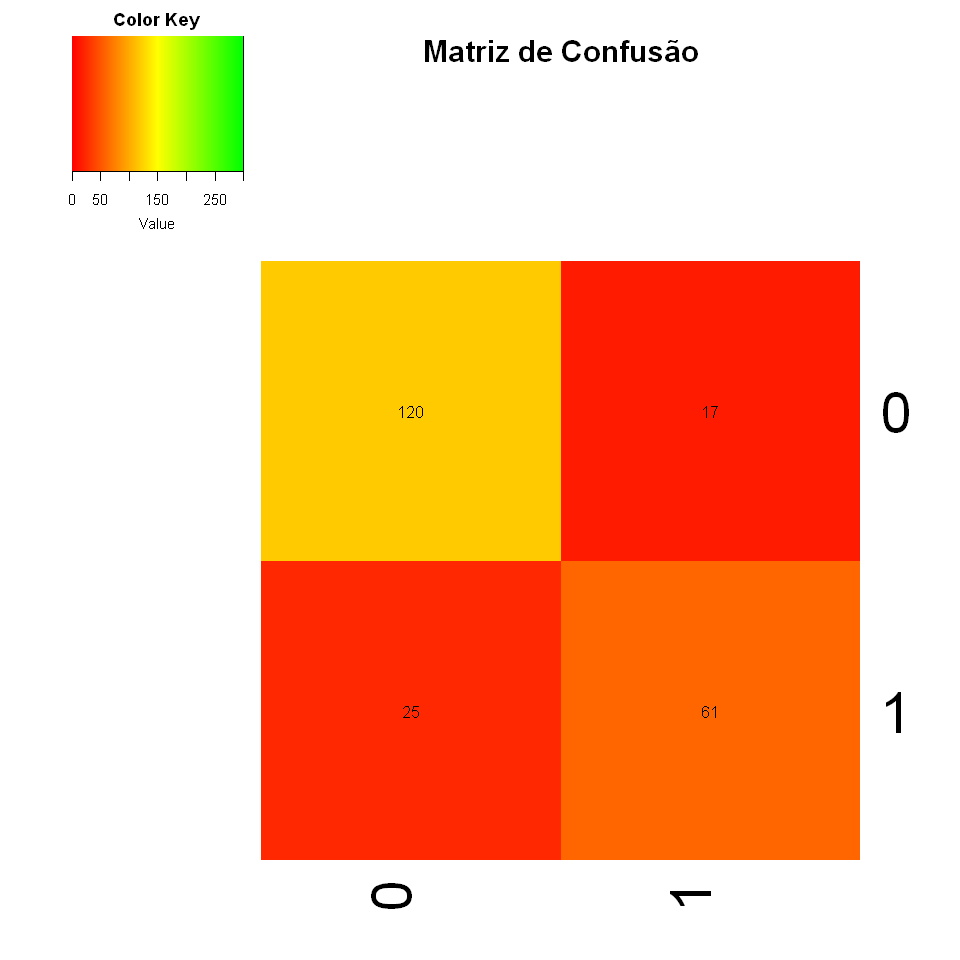

In [18]:
my_palette <- colorRampPalette(c("red", "yellow", "green"))

col_breaks = c(0:50, 51:100, 101:300)

heatmap.2(matriz_confusao,
    Rowv = 'NA',
    cellnote = matriz_confusao, 
    main = "Matriz de Confusão",
    notecol="black",      
    density.info="none",  
    trace="none",        
    col=my_palette,       
    breaks=col_breaks,   
    dendrogram= 'none',     
    Colv="NA" 
)

# Métricas

- **Precisão** que é a fração de instâncias recuperadas que são relevantes, 
- **Recall** - que é a fração de instâncias relevantes que são recuperadas 
- **f-score** - é 2 * precisão * recall / (precisão + recall) é 

In [19]:
precision(factor(previsao), factor(y_test))
'Morto'
precision(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
precision(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8275862

[1] "Morto"

[1] 0.7820513

[1] "Vivo"

[1] 0.8275862

In [20]:
recall(factor(previsao), factor(y_test))
'Morto'
recall(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
recall(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8759124

[1] "Morto"

[1] 0.7093023

[1] "Vivo"

[1] 0.8759124

In [21]:
F_meas(factor(previsao), factor(y_test))
'Morto'
F_meas(factor(previsao), factor(y_test), relevant = 2)
'Vivo'
F_meas(factor(previsao), factor(y_test), relevant = 1)

[1] 0.8510638

[1] "Morto"

[1] 0.7439024

[1] "Vivo"

[1] 0.8510638

# Ajustar Parâmetros

In [22]:
x <- cbind(x_train, y_train)
classificador <- randomForest(y_train ~ ., data = x, ntree = 500, maxnodes = 500, nodesize = 15)

previsao = predict(classificador, newdata = x_test)
acuracia = 100 * sum(previsao == y_test)/length(y_test)
acuracia

[1] 79.82063

# Validação Cruzada

- **method = cv** - indica que iremos usar o método crossvalidation
- **number = 10** - define o número de fold
- **method = rf** - indica que iremos usar o algorítmo de Floresta Aleatória

In [23]:
controle_treinamento = trainControl(method = 'cv', number = 10)
df$Survived = factor(df$Survived)
modelo = train(Survived ~ ., data = df, trControl = controle_treinamento, method = 'rf')
modelo$results

mtry,Accuracy,Kappa,AccuracySD,KappaSD
2,0.8294084,0.6315290,0.03762176,0.08100541
8,0.8416806,0.6611405,0.03487170,0.07384698
15,0.8305076,0.6386755,0.03291447,0.06646095
